In [1]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from random import shuffle

# Get the data

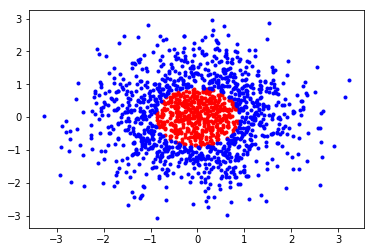

In [2]:
# number of features in
nf   = 2
# number of classes
nClass = 2

X = torch.randn(2,1500)
R = torch.sqrt(X[0,:]**2 + X[1,:]**2)
indRed   = (R < 0.9).nonzero()
indBlue  = (R >= 0.9).nonzero()


C = torch.zeros(1500,dtype = torch.int64)
C[indRed]  = 0
C[indBlue] = 1

plt.plot(X.numpy()[0,indRed],X.numpy()[1,indRed],'.r')
plt.plot(X.numpy()[0,indBlue],X.numpy()[1,indBlue],'.b')


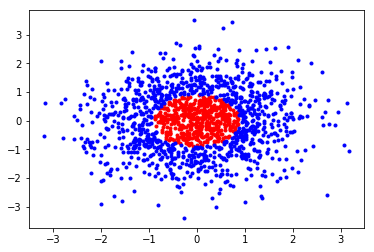

In [3]:
# Get a validation set
XVal = torch.randn(2,1500)
R = torch.sqrt(XVal[0,:]**2 + XVal[1,:]**2)
indRed   = (R < 0.9).nonzero()
indBlue  = (R >= 0.9).nonzero()


CVal = torch.zeros(1500,dtype = torch.int64)
CVal[indRed]  = 0
CVal[indBlue] = 1

plt.plot(XVal.numpy()[0,indRed],XVal.numpy()[1,indRed],'.r')
plt.plot(XVal.numpy()[0,indBlue],XVal.numpy()[1,indBlue],'.b')

# Design the simple ResNet

In [4]:
lossFunc = nn.CrossEntropyLoss()

def misfit(X,W,bias,C):
    n = W.shape
    X = X.view(n[1],-1)
    S = torch.matmul(W,X) 
    S += bias.unsqueeze(1)
    return lossFunc(S.t(),C)

In [5]:
class RK4Net(nn.Module):

    def __init__(self,NetGeo):
        super().__init__()
        
        self.NetGeo = NetGeo
        
    def forward(self,x,K,b):
        dt = self.NetGeo[1]
        nt = self.NetGeo[0]
        
        # Allocate space for all times
        X  = torch.zeros(x.shape[0],x.shape[1],nt+1)
        X[:,:,0] = x
        
        # forward Euler (to be improved later)
        for i in range(nt):
            k1 = F.relu(torch.matmul(K[i],x) + b[i])
            k2 = F.relu(torch.matmul(K[i],x+k1/2.0) + b[i])
            k3 = F.relu(torch.matmul(K[i],x+k2/2.0) + b[i])
            k4 = F.relu(torch.matmul(K[i],x+k3) + b[i])
            
            x = x + dt/6.0*(k1+k2+k3+k4)
            ind = i+1
            X[:,:,ind] = x
            
            
        return x,X 


# Initialize all parameter

In [7]:
dt = 0.1
nt = 64
NG    = [nt,dt]
net   = RK4Net(NG)

# initialize K's
K = []
for i in range(nt):
    Ki  = nn.Parameter(torch.randn(nf, nf)*1e-3)
    K.append(Ki)
    
b  = nn.Parameter(torch.randn(nt)*1e-3)
        

In [8]:
# Run the network
xF,Xpath = net(X,K,b)

In [9]:

# weights for linear classifier    
W      = nn.Parameter(torch.randn(nClass,nf)*1e-3,requires_grad=True)
bW     = nn.Parameter(torch.randn(nClass)*1e-2,requires_grad=True)

nparout = np.prod(W.shape) + np.prod(bW.shape) + np.prod(K[0].shape)*nt + nt

print('Total number of parameter',nparout)
print('Total number of data',C.shape[0])

Total number of parameter 326
Total number of data 1500


In [10]:
# run the network
x,_ = net(X,K,b)
label = C
loss = misfit(x,W,bW,label)
print('Initial loss = ', loss.detach().numpy())    
print('Sanity Check = ',np.log(2.0))

Initial loss =  0.69901544
Sanity Check =  0.6931471805599453


In [11]:
batchSize = 16

In [15]:
import torch.optim as optim
optimizer = optim.SGD([{'params': W},{'params': K},{'params': bW},{'params': b}], lr = 1e1,momentum=0.0)

In [16]:
for epoch in range(30):  # loop over the dataset multiple times

    # zero the parameter gradients
    g = 0.0
    loss = 0.0
    ind = 0
    while ind<X.shape[1]:    
        optimizer.zero_grad()
        # get the inputs
        inputs = X[:,ind:ind+batchSize]
        labels = C[ind:ind+batchSize]

        # forward 
        x,_   = net(inputs,K,b)
        lossi = misfit(x,W,bW,labels)
        if i==0:
            loss = lossi
        else:
            loss  += lossi
            
        lossi.backward()
        optimizer.step()
        g += torch.norm(W.grad) + torch.norm(bW.grad)    
        ind += batchSize
        
    print('%d  %.3f   %.3f'% (epoch+1, loss, g))

print('Finished Training')

1  163.087   58.642
2  170.575   58.046
3  142.591   51.943
4  150.561   52.736
5  137.729   54.071
6  133.699   54.139
7  93.000   41.920
8  70.261   38.116
9  16.203   16.548
10  13.465   14.032
11  11.086   12.799
12  11.911   12.829
13  11.649   12.516
14  9.663   11.058
15  9.989   11.242
16  9.302   10.616
17  8.916   10.386
18  9.113   10.492
19  8.983   10.124
20  9.237   10.369
21  9.492   10.490
22  7.995   9.338
23  7.930   9.239
24  8.017   9.293
25  8.112   9.329
26  8.434   9.583
27  8.604   9.802
28  11.020   11.040
29  10.675   10.724
30  11.004   10.737
Finished Training


# Plot the results on validation

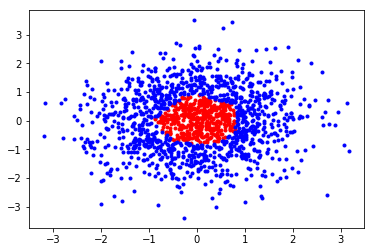

In [17]:
x,_      = net(XVal,K,b)
S      = torch.matmul(W,x)
S     += bW.unsqueeze(1)
_,Cpred = torch.max(S,dim=0)


indRed   = (Cpred==0).nonzero()
indBlue  = (Cpred==1).nonzero()


plt.plot(XVal[0,indRed].numpy(),XVal[1,indRed].numpy(),'.r')
plt.plot(XVal[0,indBlue].numpy(),XVal[1,indBlue].numpy(),'.b')


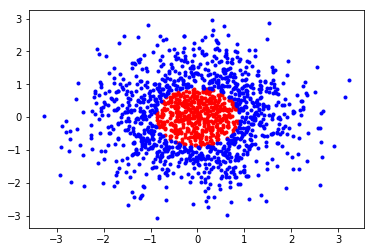

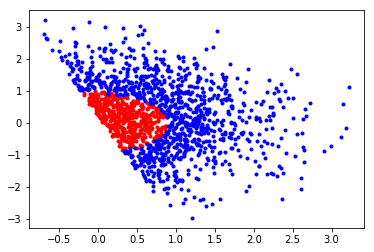

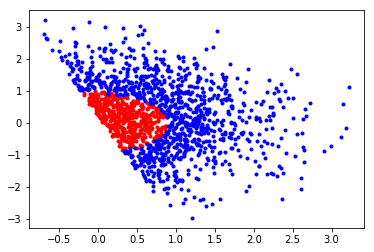

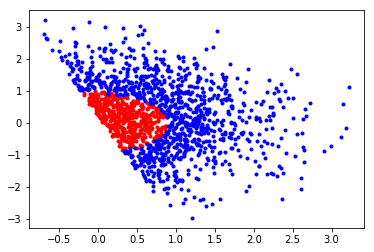

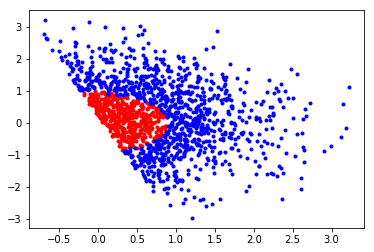

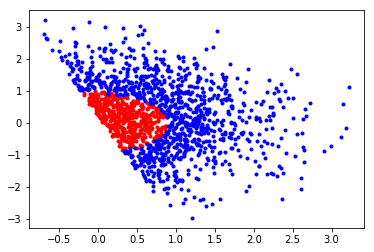

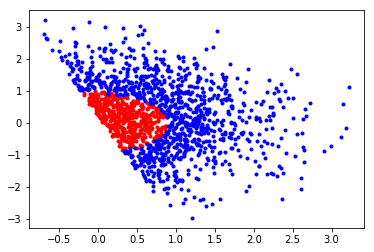

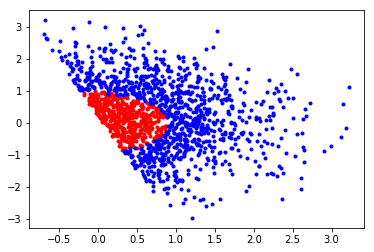

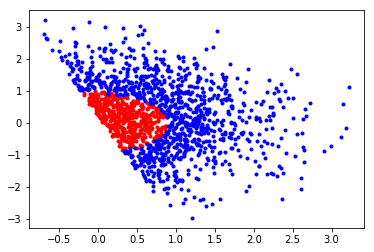

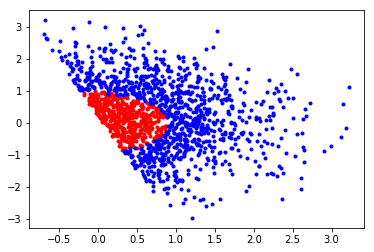

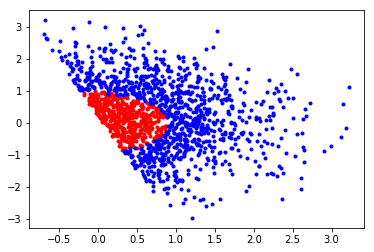

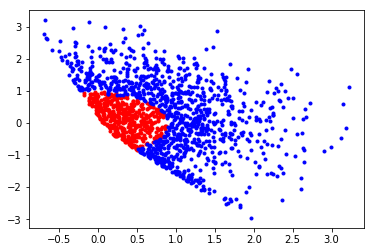

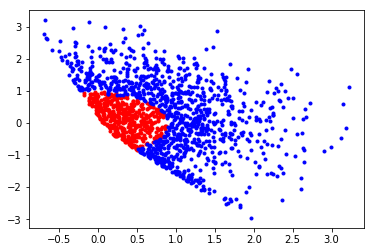

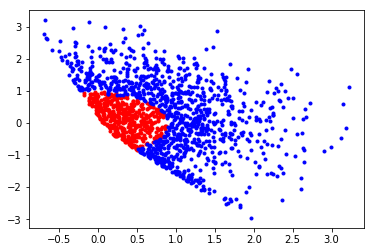

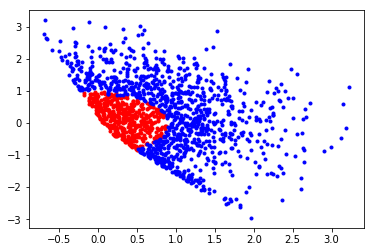

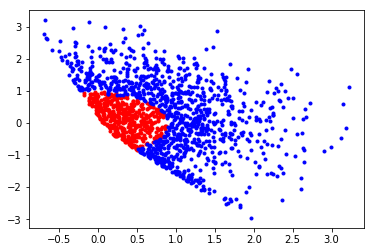

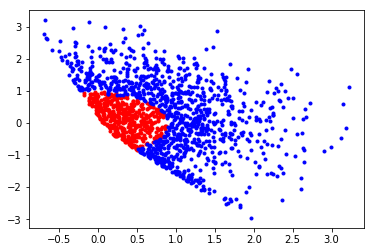

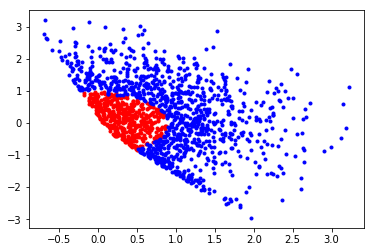

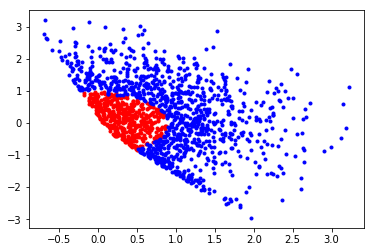

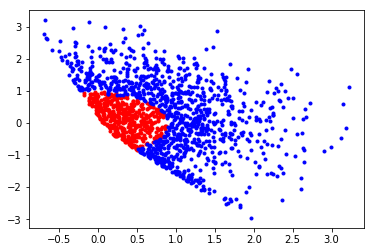

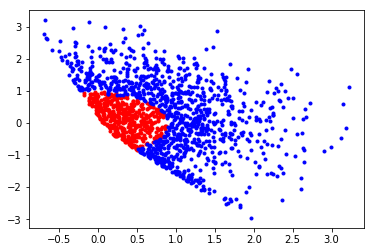

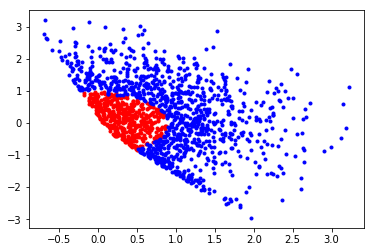

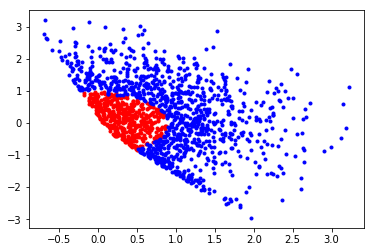

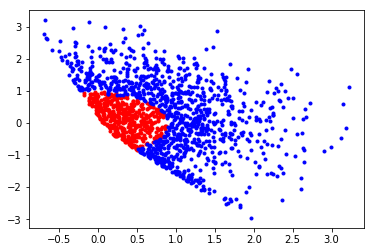

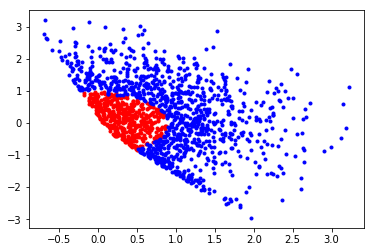

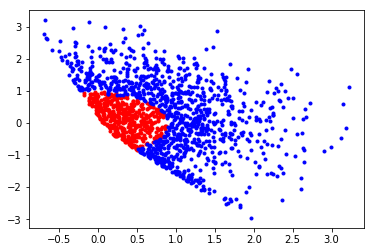

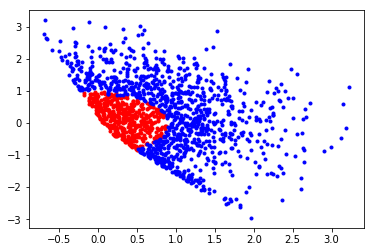

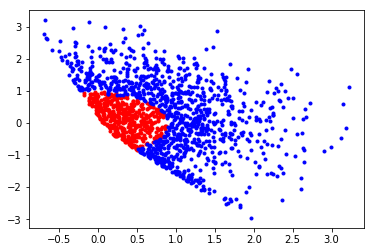

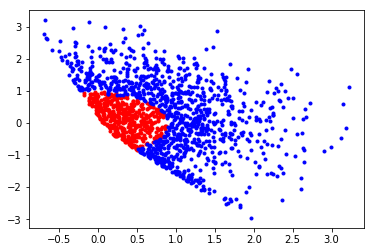

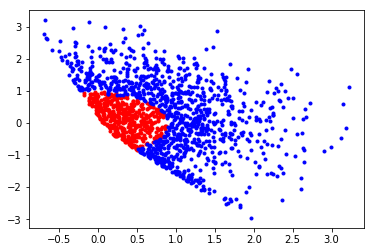

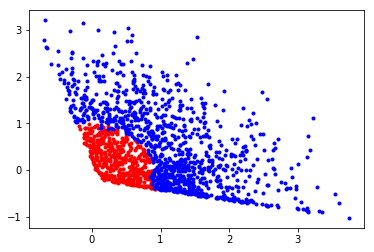

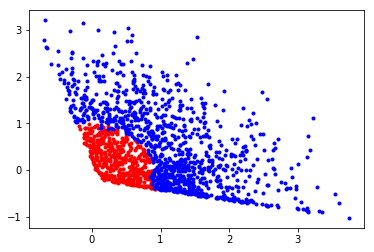

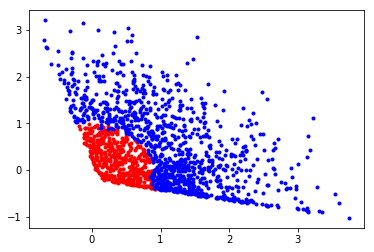

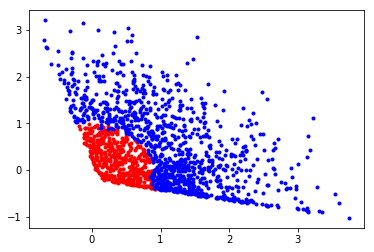

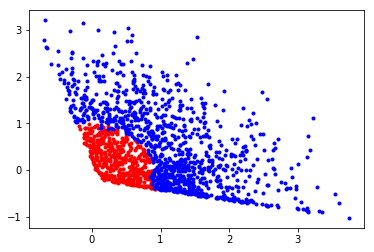

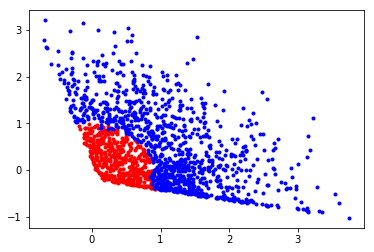

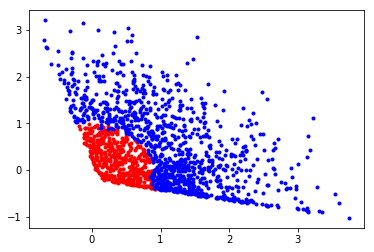

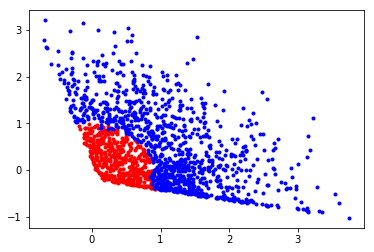

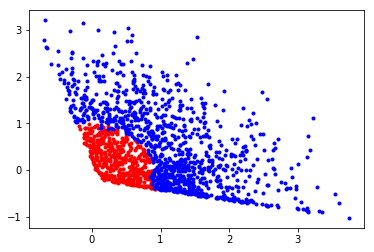

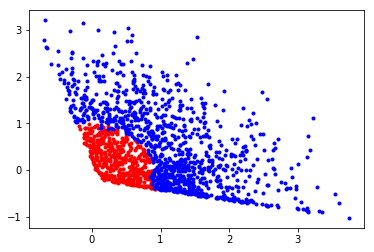

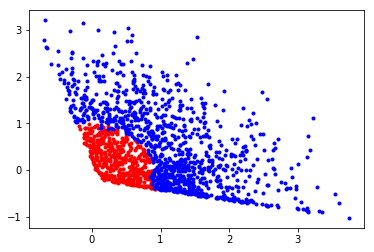

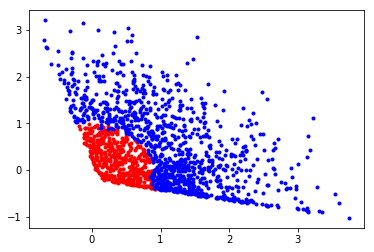

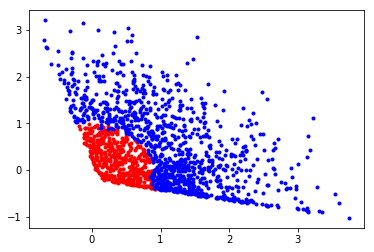

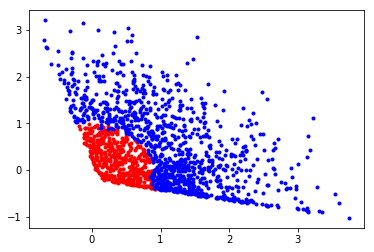

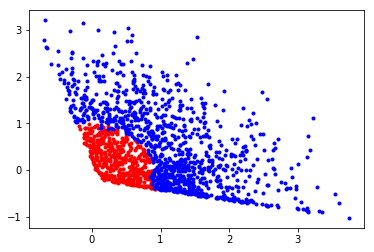

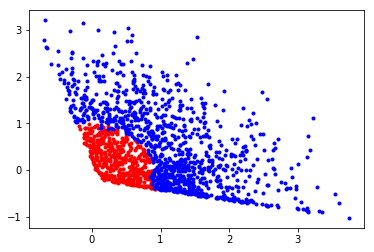

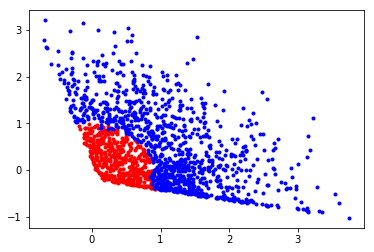

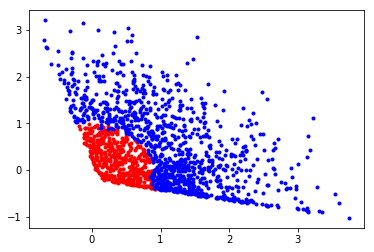

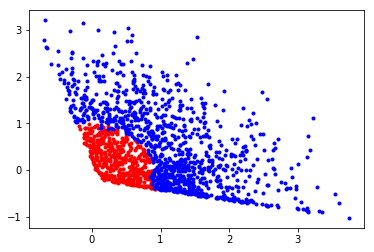

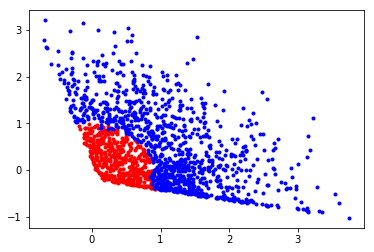

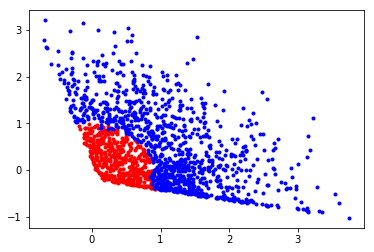

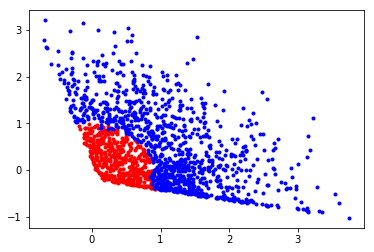

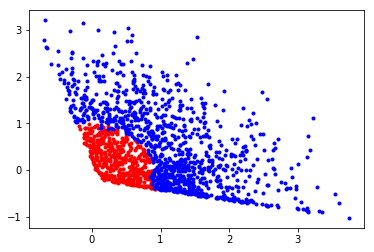

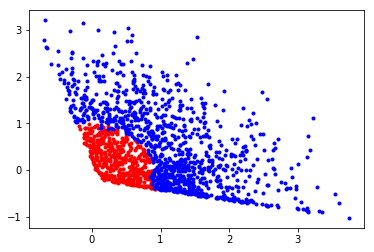

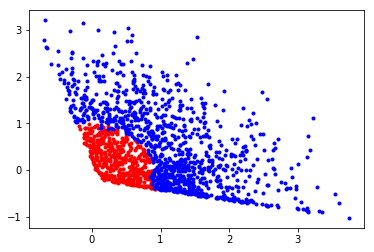

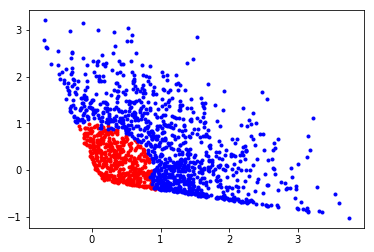

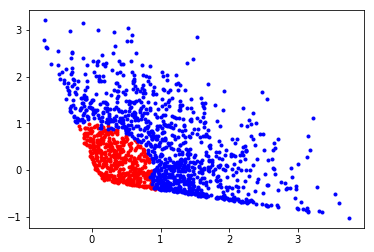

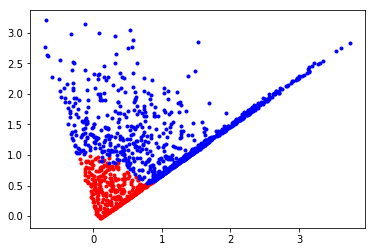

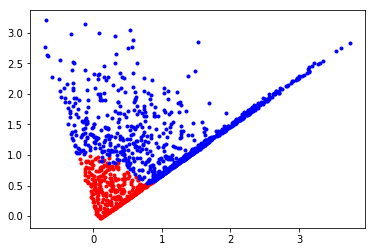

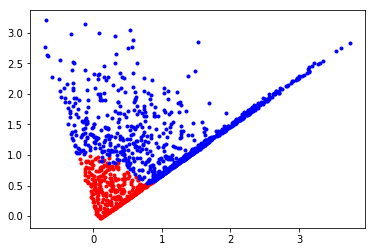

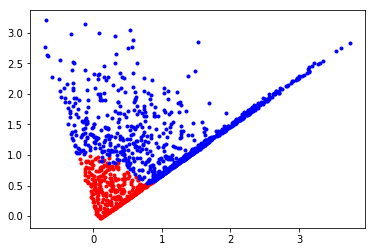

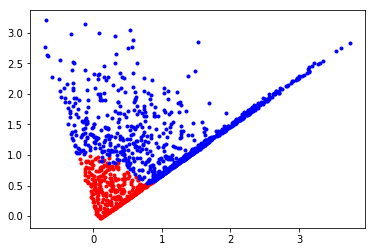

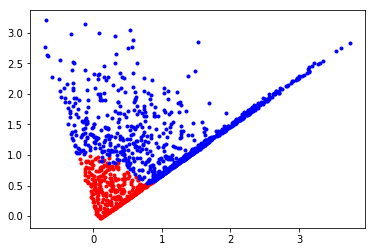

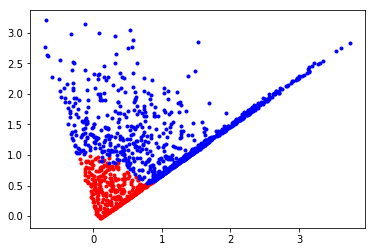

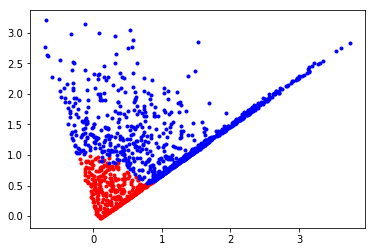

In [19]:
# plot the path
x,Xpath      = net(X,K,b)

indRed   = (C==0).nonzero()
indBlue  = (C==1).nonzero()



ax = plt.figure()

for i in range(65):
    Xi = Xpath[:,:,i].detach().numpy()
    
    ax.clf()
    plt.plot(Xi[0,indRed],Xi[1,indRed],'.r')
    plt.plot(Xi[0,indBlue],Xi[1,indBlue],'.b')

    plt.pause(0.1)